In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
sys.path.insert(0, r'C:\Users\Administrator.DAI-PC2\Desktop\DNN')

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [9]:
data_df[data_df['Name'] == 'Cristiano Ronaldo']

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M


In [10]:
# for col in data_df.columns:
#     print(f'{col}: {data_df[col].unique()}')

In [11]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18147.0,9089.239599,5257.923360,0.0,4536.5,9076.0,13662.5,18206.0
ID,18147.0,214279.818868,29970.319078,16.0,200305.5,221740.0,236512.5,246620.0
Age,18147.0,25.121122,4.669796,16.0,21.0,25.0,28.0,45.0
Overall,18147.0,66.253926,6.913320,46.0,62.0,66.0,71.0,94.0
Potential,18147.0,71.324076,6.132286,48.0,67.0,71.0,75.0,95.0
Special,18147.0,1598.002645,272.882706,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18147.0,1.113297,0.394150,1.0,1.0,1.0,1.0,5.0
Weak Foot,18147.0,2.947154,0.660498,1.0,3.0,3.0,3.0,5.0
Skill Moves,18147.0,2.361492,0.756274,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [12]:
data_df.isna().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Release Clause    1504
Length: 89, dtype: int64

In [13]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [14]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [15]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [16]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [17]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [18]:
features_df = data_df.drop('Position', axis=1)
labels_df = data_df['Position']

In [19]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df,labels_df,
                                     stratify=labels_df,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [20]:
# # important to reset the indies as we will be fetching by index

# train_df = train_df.reset_index(drop=True)
# display (train_df.head())

# test_df = test_df.reset_index(drop=True)
# display(test_df.head())

In [21]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [22]:
list(labels.keys())

[0, 1, 2, 3]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

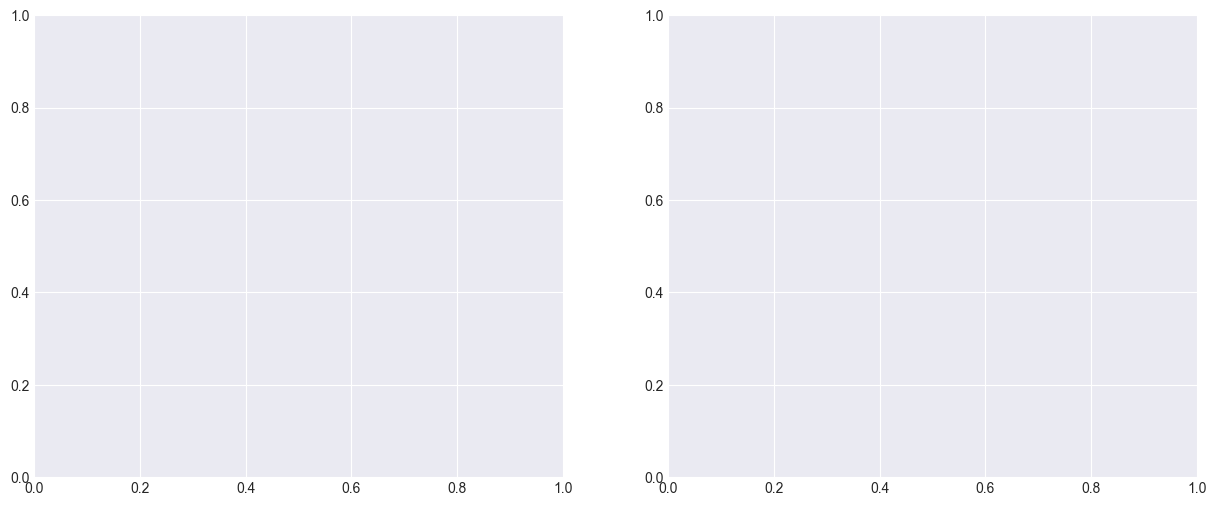

In [23]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
X_train['Position'].value_counts().plot(kind = "bar", ax = ax);

ax = axes[1]
test_df['Position'].value_counts().plot(kind = "bar", ax = ax);